In [2]:
import re
import pandas as pd 
import numpy as np 
from aerobot.io import RESULTS_PATH, MODEL_PATH
from aerobot.dataset import dataset_load_feature_order, dataset_load_all
from aerobot.kmer import kmer_sequence_to_kmers
import os 
from aerobot.models import GeneralClassifier, Nonlinear
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

The Black Sea genome data is in the form of nucleotide contigs. I ran prodigal on the raw nucleotide data (using `prodigal -i bs_contigs.fna -o bs_contigs.gbk -a bs_contigs.faa` ), which resulted in a FASTA nucleotide of amino acid sequences. Each header string contains a unique ID, e.g. GCA_014383885.1.1_3, where the first number following the genome ID (GCA_014383885.1) is the contig from which the predicted amino acid sequence was produced. 

The goal is to re-train an amino acid trimer-based classifier using only the amino acids from contigs. I can then compare the results to the performance of the whole-genome classifier by mapping the predictions from each contig to the predictions of the genome to which the contig belongs. 

In [3]:
BS_PATH = os.path.join(RESULTS_PATH, 'black_sea')

In [ ]:
aa_3mer_features = dataset_load_feature_order('aa_3mer')

# Load in the contig k-mers, which were generated by running the count-kmers.py script on HPC. 
kmer_df = pd.read_csv(os.path.join(BS_PATH, 'bs_aa_3mer_from_contigs.csv'))

In [14]:
print(f'K-mer counts generated for {len(kmer_df)} contigs.')

K-mer counts generated for 54544 contigs.


In [5]:
# The k-mer counts seem pretty sparse. In order to make sure everything worked correctly, I am going to merge the contig k-mer counts
# by genome, and compare them to the k-mer counts in the bs_aa_3mer.csv file (which Josh generated).

def get_genome_id(contig_id:str):
    '''Get the genome ID from the contig ID, which is of the form {genome_id}.{contig_index}.'''
    match = re.search('(GCA_\d+\.\d+)\.\d+', contig_id)
    return match.group(1) # Extract the genome ID from the pattern and return. 

kmer_df['genome_id'] = kmer_df.contig_id.apply(get_genome_id)
kmer_df_by_genome = kmer_df.drop(columns=['contig_id']).groupby('genome_id').sum()

In [9]:
# Load in the original k-mers. 
kmer_df_by_genome_ref = pd.read_csv(os.path.join(BS_PATH, 'bs_aa_3mer.csv'), index_col=0)

In [11]:
# Standardize the column order and k-mer counts included in each DataFrame. 
kmer_df_by_genome = kmer_df_by_genome[aa_3mer_features]
kmer_df_by_genome_ref = kmer_df_by_genome_ref[aa_3mer_features]
# Also make sure the index order matches for easier comparison. 
kmer_df_by_genome, kmer_df_by_genome_ref = kmer_df_by_genome.align(kmer_df_by_genome_ref, axis=0)

In [12]:
kmer_df_by_genome.head()

,TTA,TAT,ATG,TGG,GGT,GTW,TWS,WSI,SID,IDL,...,QCC,MYC,CQC,NCC,MYW,MWC,CMC,CNW,CCM,CWC
GCA_014381205.1,117.0,143.0,221.0,222.0,216.0,30.0,31.0,18.0,102.0,160.0,...,2.0,3.0,0.0,0.0,1.0,3.0,1.0,2.0,1.0,0.0
GCA_014381215.1,125.0,141.0,171.0,191.0,218.0,49.0,35.0,30.0,156.0,230.0,...,1.0,3.0,0.0,5.0,11.0,0.0,2.0,3.0,2.0,2.0
GCA_014381225.1,128.0,146.0,302.0,220.0,241.0,21.0,11.0,13.0,95.0,195.0,...,2.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
GCA_014381265.1,91.0,93.0,86.0,109.0,99.0,28.0,18.0,24.0,205.0,236.0,...,4.0,3.0,1.0,5.0,2.0,0.0,2.0,8.0,1.0,0.0
GCA_014381285.1,107.0,128.0,118.0,134.0,153.0,12.0,18.0,19.0,196.0,228.0,...,1.0,2.0,2.0,6.0,7.0,4.0,1.0,2.0,2.0,0.0


In [13]:
# Counts in the reference and contig-based k-mer DataFrames seem very similar, though not identical. I am pretty sure Prodigal is 
# deterministic, so perhaps Josh used a different set of contigs, or erged the contig sequences before counting k-mers. I 
# will note that it seems as though the counts in the reference are consistently higher than the counts I generated, so that
# explanation is plausible. 
kmer_df_by_genome_ref.head()

,TTA,TAT,ATG,TGG,GGT,GTW,TWS,WSI,SID,IDL,...,QCC,MYC,CQC,NCC,MYW,MWC,CMC,CNW,CCM,CWC
GCA_014381205.1,135.0,162.0,215.0,217.0,213.0,37.0,34.0,19.0,102.0,173.0,...,2.0,4.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0
GCA_014381215.1,124.0,141.0,170.0,193.0,216.0,47.0,36.0,30.0,154.0,223.0,...,1.0,3.0,0.0,6.0,11.0,0.0,2.0,3.0,2.0,2.0
GCA_014381225.1,129.0,151.0,294.0,219.0,239.0,21.0,12.0,14.0,95.0,193.0,...,2.0,3.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0
GCA_014381265.1,88.0,91.0,83.0,103.0,98.0,28.0,18.0,24.0,199.0,231.0,...,3.0,3.0,1.0,5.0,2.0,0.0,2.0,8.0,0.0,0.0
GCA_014381285.1,106.0,120.0,117.0,129.0,149.0,12.0,17.0,19.0,191.0,221.0,...,0.0,2.0,2.0,6.0,7.0,4.0,1.0,2.0,1.0,0.0


We have trained amino acid trimer-based models (both logistic and nonlinear) saved in the notebooks directory. These can be used to generate predictions for the contig trimers. Predictions needed to be generated on the HPC (they require too much memory to run locally).

In [5]:
predictions = dict()
# Load the predictions from contig-derived k-mers. 
predictions['from_contigs'] = pd.read_csv(os.path.join(BS_PATH, 'bs_predictions_nonlinear_aa_1mer_from_contigs.csv'))
# Load the predictions from genome-derived k-mers. 
predictions['from_genomes'] = pd.read_csv(os.path.join(BS_PATH, 'bs_predictions_nonlinear_aa_3mer.csv'))

In [6]:
# Get some information on the predictions for each dataset. 
for origin, predictions in predictions.items():
    n_aerobe = np.sum(predictions.prediction.str.fullmatch('aerobe'))
    n_anaerobe = np.sum(predictions.prediction.str.fullmatch('anaerobe'))
    n_facultative = np.sum(predictions.prediction.str.fullmatch('facultative'))

    print(f'Aerobe fraction {origin}:', n_aerobe / len(predictions))
    print(f'Anaerobe fraction {origin}:', n_anaerobe / len(predictions))
    print(f'Facultative fraction {origin}:', n_facultative / len(predictions))
    print()

Aerobe fraction from_contigs: 0.0
Anaerobe fraction from_contigs: 0.0
Facultative fraction from_contigs: 1.0

Aerobe fraction from_genomes: 0.225
Anaerobe fraction from_genomes: 0.71875
Facultative fraction from_genomes: 0.05625



In [33]:
# I am a bit curious as to why there is a bias towards facultative in the 1-mer case and a bias towards anaerobes in the 3-mer case.
# I am going to take a look at what the contig embeddings look like in dimensionally-reduced space. 

feature_type = 'aa_2mer'

features = dataset_load_feature_order(feature_type)
# First need to load the scaler from the trained model. 
model = GeneralClassifier(Nonlinear, params={'input_dim':len(features)})
model = model.load(os.path.join(MODEL_PATH, f'{feature_type}_nonlinear_model.joblib'))
scaler = model.scaler

# Use the scaler to scale the raw k-mer data. 
kmers = pd.read_csv(os.path.join(BS_PATH, f'bs_{feature_type}_from_contigs.csv'))[features]
# kmers = scaler.transform(kmers.values)


In [45]:
scaler.mean_


array([ 3654.94992413,  6208.75265554,  5782.82852807,  5453.98330804,
        6929.98179059,  5016.88163885,   742.72230653,   845.25493171,
        3989.34294385,  4280.82701062,  6260.15326252, 12195.51441578,
        3455.82549317,  4209.0030349 ,  4908.47647951,  5080.61305008,
        6737.84825493,  7452.26707132,  4112.09863429,  3500.79817906,
        3292.50682853,  3255.41122914,  7947.85735964,  2322.67223065,
        5072.59939302,  6074.0091047 ,  3456.9939302 ,  6132.77086495,
       13241.46737481,  9251.87556904,  3003.91198786,  2257.2306525 ,
        3604.91502276,  4210.69195751,  2287.27010622,  4131.1016692 ,
       11894.94081942,  6479.09863429,  3742.65553869,  3115.96661608,
        6535.10015175,  5663.81638847,  3412.11836115,  4601.95144158,
        5431.10015175,  8372.31866464,  2421.30652504,  2399.73748103,
        2748.7693475 ,  4980.93778452,  5822.73444613,  6960.05766313,
        6740.15174507,  3592.5538695 ,  5823.81031866,  1832.94081942,
      

In [34]:
# Probably should compare to training set embeddings. 
ref_kmers_dataset = dataset_load_all(feature_type, to_numpy=False)
ref_kmers = ref_kmers_dataset['features'][features]
# ref_kmers = scaler.transform(ref_kmers.values) # Also need to scale these with the same scaler!

In [35]:
ref_kmer_predictions = model.predict(ref_kmers.values).ravel()

In [46]:
pca = PCA(n_components=2)

all_kmers = np.concatenate([ref_kmers, kmers], axis=0)
components = pca.fit_transform(all_kmers)
# components = pca.fit_transform(kmers)

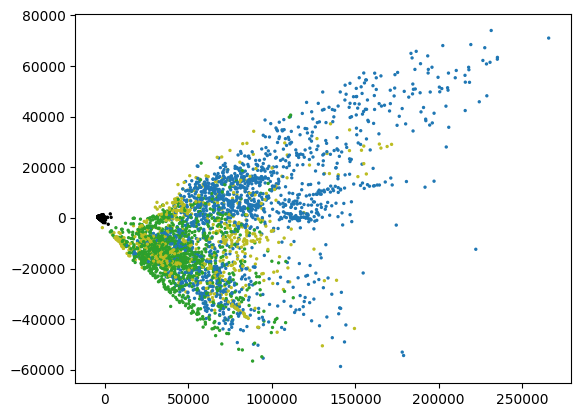

In [47]:
fig, ax = plt.subplots()

# labels = ref_kmers_dataset['labels'].physiology.values
labels = np.concatenate([ref_kmer_predictions, np.array(['contig'] * len(kmers))], axis=0)
colors = {'aerobe':'tab:blue', 'anaerobe':'tab:green', 'facultative':'tab:olive', 'contig':'black'}

ax.scatter(components[:, 0], components[:, 1], s=2, c=[colors[l] for l in labels])
# ax.scatter(components[:, 0], components[:, 1], s=2) # , c=[colors[l] for l in labels])

# TODO: Should do this with the predicted labels, not the true labels.
plt.show()

In [32]:
np.count_nonzero(kmer_predictions == 'facultative')

54544

I wonder if the poor predictions for contigs are partly related to the `StandardScaler`, which has been fit to the training data. I have a feeling this is causing the contigs to have mostly negative values.